In [2]:
%load_ext autoreload
%autoreload 1
%autosave 60

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 60 seconds


In [3]:
from cortex import CortexDataset

[2019-12-23 11:51:03,551] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.


In [4]:
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer

C:\Users\Zacharie\AppData\Local\conda\conda\envs\scvi\lib\site-packages\sklearn\utils\linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [5]:
%aimport scVI_vae

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection._split import _validate_shuffle_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (silhouette_score,
                             normalized_mutual_info_score as NMI,
                             adjusted_rand_score as ARI)


In [7]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110

###### Split dataset function

In [8]:
"""
def data_loader(dataset):
    np.random.seed(seed=0)
    val_idx = []
    labels = np.unique(dataset.labels)
    for i in range(len(labels)) : 
        idx = np.argwhere(dataset.labels == i).T[0]
        val_idx.append(np.random.choice(idx, 100))
    val_idx = np.array(val_idx).ravel()
    x_train = np.delete(dataset.X, val_idx, axis=0)
    x_train = np.log(x_train + 1)
    y_train = np.delete(dataset.labels, val_idx, axis=0)
    x_val = np.log(dataset.X[val_idx, :] + 1)
    y_val = dataset.labels[val_idx, :]
    return x_train, y_train, x_val,y_val
"""

'\ndef data_loader(dataset):\n    np.random.seed(seed=0)\n    val_idx = []\n    labels = np.unique(dataset.labels)\n    for i in range(len(labels)) : \n        idx = np.argwhere(dataset.labels == i).T[0]\n        val_idx.append(np.random.choice(idx, 100))\n    val_idx = np.array(val_idx).ravel()\n    x_train = np.delete(dataset.X, val_idx, axis=0)\n    x_train = np.log(x_train + 1)\n    y_train = np.delete(dataset.labels, val_idx, axis=0)\n    x_val = np.log(dataset.X[val_idx, :] + 1)\n    y_val = dataset.labels[val_idx, :]\n    return x_train, y_train, x_val,y_val\n'

In [9]:
# paper's implementation 
def train_test_validation(
        gene_dataset=None,
        train_size=0.8, # same train size as in the paper
        test_size=None,
    ):
        """Creates posteriors ``train_set``, ``test_set``, ``validation_set``.
            If ``train_size + test_size < 1`` then ``validation_set`` is non-empty.
            :param train_size: float, int, or None (default is 0.1)
            :param test_size: float, int, or None (default is None)
            """
        gene_dataset = (
            self.gene_dataset
            if gene_dataset is None and hasattr(self, "model")
            else gene_dataset
        )
        n = len(gene_dataset)
        try:
            n_train, n_test = _validate_shuffle_split(n, test_size, train_size)
        except ValueError:
            if train_size != 1.0:
                raise ValueError(
                    "Choice of train_size={} and test_size={} not understood".format(
                        train_size, test_size
                    )
                )
            n_train, n_test = n, 0
        random_state = np.random.RandomState(seed=0) # same seed as in the paper
        permutation = random_state.permutation(n)
        indices_test = permutation[:n_test]
        indices_train = permutation[n_test : (n_test + n_train)]
        indices_validation = permutation[(n_test + n_train) :]
        return indices_train, indices_test, indices_validation

###### Plot function

In [10]:
def plot_latent(X, y, labels):
    #labels = np.unique(y)
    palette = cm.get_cmap('viridis', 6)
    fig, ax = plt.subplots()
    for i in range(len(labels)) :
        color = palette(i / len(labels))
        scatter = ax.scatter(x = X[np.argwhere(y == i)].T[0], y = X[np.argwhere(y== i)].T[1], c = color, label = labels[i], s=10, alpha=0.8)
    ax.legend()
    ax.grid()
    plt.tight_layout()

In [11]:
# paper's implementation

def apply_t_sne(latent, n_samples=1000):
    idx_t_sne = (
        np.random.permutation(len(latent))[:n_samples]
        if n_samples
        else np.arange(len(latent))
    )
    if latent.shape[1] != 2:
        latent = TSNE().fit_transform(latent[idx_t_sne])
    return latent, idx_t_sne

# Load Cortex dataset

In [12]:
cortex_dataset = CortexDataset(save_path="./data/", total_genes=558)

[2019-12-23 11:51:21,403] INFO - scvi.dataset.dataset | File C:\Users\Zacharie\Documents\Ecole\Poly session 7 - A2019\IFT6269 - Modèles graphiques probabilistes et apprentissage\umontreal-ift6269-pgm\data\expression.bin already downloaded
[2019-12-23 11:51:44,171] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-12-23 11:51:44,175] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]


7 neuronal cells lines in Cortex :

In [13]:
labels = np.unique(cortex_dataset.labels)
print(labels)

[0 1 2 3 4 5 6]


#### Split dataset 

In [14]:
idx_train, idx_test, _ = train_test_validation(cortex_dataset)
x_train = cortex_dataset.X[idx_train]
x_train = np.log(x_train + 1)
y_train = cortex_dataset.labels[idx_train]
x_test = cortex_dataset.X[idx_test]
x_test = np.log(x_test + 1)
y_test = cortex_dataset.labels[idx_test]

# Hyperparameters

In [15]:
N_EPOCHS = 250
LR = 0.0004
BATCH_SIZE = 32
use_batches = False
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda:0" if USE_CUDA else "cpu")

# Training our scVI reimplementation (v1)

In [17]:
model_1 = scVI_vae.scVI_vae(n_genes = cortex_dataset.nb_genes)
losses_train_1, losses_test_1 = scVI_vae.train_scvi(model_1, x_train, x_test, n_epochs=N_EPOCHS)
latent_space_1 = model_1.infer_z_posterior(x_train).detach().cpu()

# Training our alternative scVI reimplementation (v2)

In [18]:
%aimport vae
%aimport train

In [ ]:
model_2 = vae.VAE(input_dim=558, hidden_dim=128, latent_dim=10, n_layers=1, dropout=0.1, use_log_variational=False)
losses_train_2, losses_val_2 = train.train(model_2, x_train, x_test, BATCH_SIZE, N_EPOCHS, LR, verbose=0)

In [23]:
_, _, latent_space_2 = model_2.z_encoder(torch.tensor(x_train).to(DEVICE))
latent_space_2 = latent_space_2.detach().cpu()

# Training the paper's scVI implementation (v3)

In [ ]:
model_3 = VAE(cortex_dataset.nb_genes, n_batch=32, log_variational=False)
trainer_cortex = UnsupervisedTrainer(model_3, cortex_dataset, train_size=0.9, use_cuda=USE_CUDA, frequency=1)
trainer_cortex.train(n_epochs=N_EPOCHS)
losses_train_3 = trainer_cortex.history["elbo_train_set"]
losses_val_3 = trainer_cortex.history["elbo_test_set"]

In [36]:
latent_space_3 = model_3.sample_from_posterior_z(torch.tensor(x_train).to(DEVICE)).detach().cpu()

# Clustering on latent space

In [43]:
from clustering import plot_clustering, accuracy

In [51]:
gmm = GaussianMixture(
    n_components=7,
    covariance_type='full',
    max_iter=100,
    n_init=10,
    init_params='kmeans')

kmeans = KMeans(
    n_clusters=7,
    init='k-means++',
    n_init=200,
    max_iter=300)

models = dict()
models["model_1"] = {"latent": latent_space_1}
models["model_2"] = {"latent": latent_space_2}
models["model_3"] = {"latent": latent_space_3}

for model in models.values():
    latent = model["latent"]
    model["tsne"] = TSNE(2).fit_transform(latent)

In [53]:
models["model_1"]["gmm"] = {}
models["model_1"]["kmeans"] = {}
models["model_2"]["gmm"] = {}
models["model_2"]["kmeans"] = {}
models["model_3"]["gmm"] = {}
models["model_3"]["kmeans"] = {}

In [61]:
for model in models.values():
    latent = model["latent"]
    clust = {"gmm": gmm.fit_predict(latent), "kmeans": kmeans.fit_predict(latent)}
    for method, clusters in clust.items():
        model[method]["labels"] = clusters
        model[method]["silhouette"] = silhouette_score(latent, clusters)
        model[method]["nmi"] = NMI(y_train.ravel(), clusters, average_method="geometric")
        model[method]["ari"] = ARI(y_train.ravel(), clusters)
        model[method]["accuracy"] = accuracy(y_train.ravel(), clusters)

In [64]:
for model_name, model in models.items():
    print(model_name)
    print("  true labels")
    print("    ", silhouette_score(model["latent"], y_train.ravel()))
    for clust in ["gmm", "kmeans"]:
        print("  ", clust)
        for metric in ["silhouette", "nmi", "ari", "accuracy"]:
            print("    ", metric, model[clust][metric])

model_1
  true labels
     0.12751737
   gmm
     silhouette 0.1252086
     nmi 0.7512176389077332
     ari 0.7368207188887133
     accuracy 0.8473377703826955
   kmeans
     silhouette 0.13220029
     nmi 0.6747368631632448
     ari 0.6196957698650123
     accuracy 0.7695507487520798
model_2
  true labels
     0.15960303
   gmm
     silhouette 0.1252633
     nmi 0.7098079790888847
     ari 0.5916021514910554
     accuracy 0.7520798668885191
   kmeans
     silhouette 0.16230401
     nmi 0.735381785550539
     ari 0.6833880146684683
     accuracy 0.8061564059900166
model_3
  true labels
     0.1251786
   gmm
     silhouette 0.14509407
     nmi 0.6463318462730309
     ari 0.6301439431097575
     accuracy 0.7778702163061564
   kmeans
     silhouette 0.18880276
     nmi 0.5203349090830212
     ari 0.39683136697418325
     accuracy 0.6031613976705491


In [101]:
named_labels = y_train.ravel().astype("U20")
for i, name in enumerate(cortex_dataset.cell_types):
    named_labels[y_train.ravel() == i] = name.replace("_", " ").replace("-", " ")

0


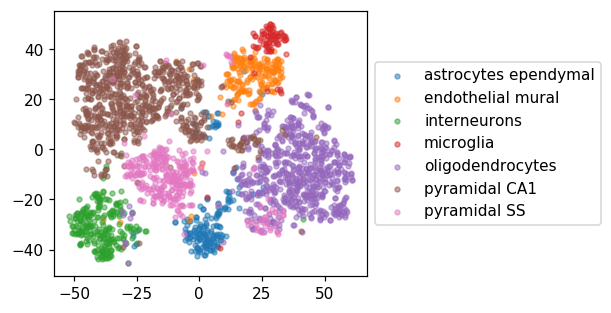

0


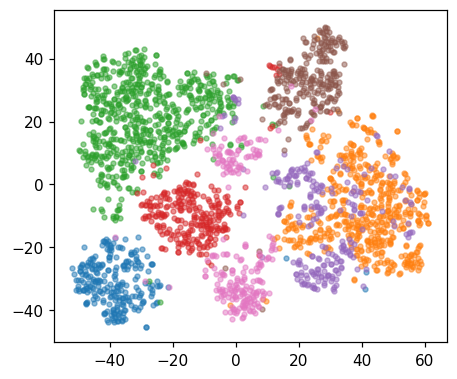

0


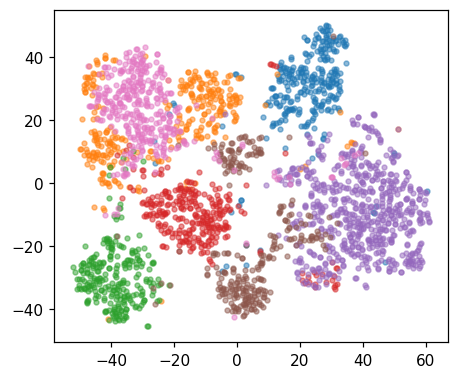

In [103]:
model = models["model_1"]
tsne = model["tsne"]
plot_clustering(tsne, named_labels, True, save_path="figures/true_labels.png")
for clust in ["gmm", "kmeans"]:
    plot_clustering(tsne, model[clust]["labels"], save_path="figures/"+clust+"_labels.png")